In [1]:
#%load_ext autoreload
#%autoreload 2

import os
import hydromt
from hydromt_summa.summa import SummaModel
from hydromt import workflows, flw
import xarray as xr
from hydromt.log import setuplog
import numpy as np
import time
import pysumma as ps

/home/ayx374/.local/easybuild/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(
/home/ayx374/.local/easybuild/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
import netCDF4

ImportError: /home/ayx374/.local/easybuild/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.8/site-packages/netCDF4/_netCDF4.cpython-38-x86_64-linux-gnu.so: undefined symbol: ompi_mpi_info_null

In [2]:
# import from dask for parallel processing
from dask_jobqueue import SLURMCluster
from dask.distributed import Client

def elapsed(start):
    return str(time.time() - start) + ' seconds'

In [3]:
data_catalogue_path = os.path.join(os.path.expanduser("~"),'projects','rpp-kshook','CompHydCore','datacatalog.yml')
logger = setuplog('test_datacat', log_level=10)
data_catalog = hydromt.DataCatalog(data_catalogue_path, logger=logger)

2022-09-16 16:07:10,192 - test_datacat - log - INFO - HydroMT version: 0.5.1.dev
2022-09-16 16:07:10,194 - test_datacat - data_catalog - INFO - Parsing data catalog from /home/ayx374/projects/rpp-kshook/CompHydCore/datacatalog.yml


In [25]:
root = os.path.join('./summa_bowatbanff_shapes_2008')
mod = SummaModel(root=root, mode="w",
                  data_libs=[data_catalogue_path])

In [26]:
_region = {'geom': './test_shapes/bow_distributed_elevation_zone.shp'}

<AxesSubplot:>

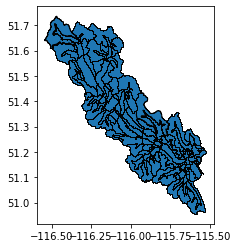

In [27]:
r = mod.setup_region(_region)
r['geom'].plot(edgecolor='black',categorical=True)

2022-09-16 16:18:19,260 - test_datacat - data_catalog - INFO - DataCatalog: Getting merit_hydro RasterDataset raster data from /home/ayx374/projects/rpp-kshook/CompHydCore/merit_hydro/vrts/*/{variable}.vrt
2022-09-16 16:18:19,487 - test_datacat - rasterdataset - DEBUG - RasterDataset: Clip with geom - [-116.544, 50.955, -115.525, 51.735]


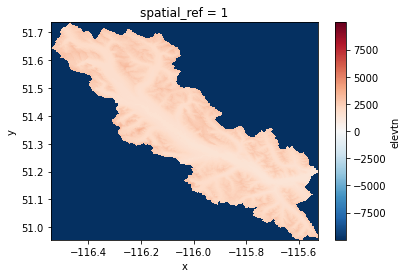

In [28]:
dsm = data_catalog.get_rasterdataset('merit_hydro',geom=mod.region)
dsm_clip = dsm.raster.clip_geom(mod.region, mask=True)
dsm_clip['elevtn'].plot()

In [29]:
mod.setup_response_unit(
    hydrography_fn="merit_hydro",
    split_regions = False,
    index_col = "HRU_ID",
    
)
mod.set_response_units(mod.response_units.sortby(['GRU_ID','HRU_ID']))
mod.response_units

<xarray.Dataset>
Dimensions:      (index: 118)
Coordinates:
  * index        (index) int64 48 97 118 1 49 100 2 50 ... 93 45 94 46 95 47 96
    geometry     (index) object POLYGON ((-115.57375 51.150416663845334, -115...
    spatial_ref  int64 0
Data variables:
    GRU_ID       (index) object '71028585' '71028585' ... '71032440' '71032440'
    HRU_ID       (index) int64 48 97 118 1 49 100 2 50 ... 93 45 94 46 95 47 96
    center_lat   (index) float64 51.15 51.16 51.17 51.19 ... 51.65 51.67 51.66
    center_lon   (index) float64 -115.6 -115.6 -115.6 ... -116.3 -116.5 -116.4
    HRU_area     (index) float64 5.081e+05 1.616e+06 ... 8.694e+07 2.007e+07

In [11]:
# set up a dask cluster for parallel processing of forcing data
cluster = SLURMCluster(project='rpp-kshook',
                      cores=1,
                      memory="1000MB",
                   walltime='00:15:00')
client = Client(cluster)

In [12]:
# scale to the number of months (number of time chunks)
cluster.scale(12)
# give time to start up
time.sleep(30)

In [37]:
!squeue -u $USER

            JOBID     USER              ACCOUNT           NAME  ST  TIME_LEFT NODES CPUS TRES_PER_N MIN_MEM NODELIST (REASON) 
         65273602   ayx374       rpp-kshook_cpu    dask-worker   R       1:53     1    1        N/A    954M gra285 (None) 
         65273603   ayx374       rpp-kshook_cpu    dask-worker   R       1:53     1    1        N/A    954M gra703 (None) 
         65273542   ayx374       rpp-kshook_cpu    interactive   R    2:37:00     1    4        N/A      2G gra796 (None) 


In [31]:
mod.setup_forcing('era5_for_summa', get_rasterdataset_kwargs = {'time_tuple':('2008-01-01 00:00','2008-12-31'),'parallel':True}, all_touched=True)

In [32]:
mod.forcing

{'LWRadAtm_mean': <xarray.DataArray 'LWRadAtm_mean' (index: 118, time: 8784)>
 dask.array<concatenate, shape=(118, 8784), dtype=float32, chunksize=(1, 744), chunktype=numpy.ndarray>
 Coordinates:
   * time         (time) datetime64[ns] 2008-01-01 ... 2008-12-31T23:00:00
     spatial_ref  int64 1
   * index        (index) int64 48 97 118 1 49 100 2 50 ... 93 45 94 46 95 47 96,
 'SWRadAtm_mean': <xarray.DataArray 'SWRadAtm_mean' (index: 118, time: 8784)>
 dask.array<concatenate, shape=(118, 8784), dtype=float32, chunksize=(1, 744), chunktype=numpy.ndarray>
 Coordinates:
   * time         (time) datetime64[ns] 2008-01-01 ... 2008-12-31T23:00:00
     spatial_ref  int64 1
   * index        (index) int64 48 97 118 1 49 100 2 50 ... 93 45 94 46 95 47 96,
 'pptrate_mean': <xarray.DataArray 'pptrate_mean' (index: 118, time: 8784)>
 dask.array<concatenate, shape=(118, 8784), dtype=float32, chunksize=(1, 744), chunktype=numpy.ndarray>
 Coordinates:
   * time         (time) datetime64[ns] 2008-01-

In [38]:
#%% write model specific files
time1 = time.time()
mod.write_forcing()
print('Result computed:', elapsed(time1))

NameError: name 'netCDF4' is not defined

In [26]:
mod.setup_soilclass('usda_soilclass',all_touched=True)

In [27]:
# one of the HRUs has no area (artefact) set random landclass
mod.response_units.tax_usda_count_mode.loc[dict(index=116)]=3.0

In [28]:
mod.setup_elevation()

In [29]:
mod.setup_landclass('modis_landclass_vrt4326')

In [27]:
# kill client and workers
client.shutdown()
# give time to shut down
time.sleep(10)
!squeue -u $USER

            JOBID     USER              ACCOUNT           NAME  ST  TIME_LEFT NODES CPUS TRES_PER_N MIN_MEM NODELIST (REASON) 
         65269768   ayx374       rpp-kshook_cpu    interactive   R       1:41     1    4        N/A      2G gra797 (None) 


2022-09-16 16:01:01,105 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


In [40]:
mod.response_units

<xarray.Dataset>
Dimensions:               (index: 118, soil: 4, landclass: 10)
Coordinates:
  * index                 (index) int64 48 97 118 1 49 100 ... 45 94 46 95 47 96
    geometry              (index) object POLYGON ((-115.57375 51.150416663845...
    spatial_ref           int64 0
  * soil                  (soil) float32 0.0 3.0 8.0 12.0
  * landclass             (landclass) uint8 1 7 8 9 10 11 13 15 16 17
Data variables:
    GRU_ID                (index) object '71028585' '71028585' ... '71032440'
    HRU_ID                (index) int64 48 97 118 1 49 100 ... 45 94 46 95 47 96
    center_lat            (index) float64 51.15 51.16 51.17 ... 51.67 51.66
    center_lon            (index) float64 -115.6 -115.6 -115.6 ... -116.5 -116.4
    HRU_area              (index) float64 5.081e+05 1.616e+06 ... 2.007e+07
    tax_usda_count        (index, soil) int64 0 17 0 0 0 48 ... 402 1 0 466 38 0
    tax_usda_fraction     (index, soil) float64 0.0 1.0 0.0 ... 0.0754 0.0
    tax_usda_count_mode   (index) float32 3.0 3.0 3.0 3.0 ... 3.0 8.0 3.0 3.0
    elevtn_mean           (index) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    landclass_fraction    (index, landclass) float64 1.0 0.0 ... 0.04636 0.05298
    landclass_count_mode  (index) uint8 1 1 8 10 8 8 10 8 ... 10 10 9 10 8 10 1
    down_id               (index) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [48]:
mod.write_response_units()

In [49]:
#%% write model specific files
mod.write_filemanager()
mod.copy_base_files()
mod.write_states()
mod.write_trial_params()

IsADirectoryError: [Errno 21] Is a directory: '/home/ayx374/Github/hydromt_summa/hydromt_summa/data/base_settings/.ipynb_checkpoints'

In [43]:
#%% write model specific files
mod.set_response_units(np.zeros(len(mod.response_units.index)), name='down_id')
mod.write_attributes()

In [59]:
# Define location of .exe and file manager
executable = '/home/ayx374/installs/summa/bin/summa.exe'
# read model as pysumma simulation object
mod.read(summa_exe=executable)

In [63]:
mod.Simulation.manager_path

PosixPath('/home/ayx374/Github/hydromt_summa/examples/graham/summa_bowatbanff_shapes_2008/fileManager.txt')

In [124]:
# set up a dask cluster for parallel running of the SUMMA model
cluster = SLURMCluster(project='rpp-kshook',
                      cores=1,
                      memory="1000MB",
                   walltime='00:15:00')
client = Client(cluster)
cluster.scale(5)
time.sleep(30)
!squeue -u $USER

            JOBID     USER              ACCOUNT           NAME  ST  TIME_LEFT NODES CPUS TRES_PER_N MIN_MEM NODELIST (REASON) 
         65272975   ayx374       rpp-kshook_cpu    dask-worker   R      14:48     1    1        N/A    954M gra702 (None) 
         65272976   ayx374       rpp-kshook_cpu    dask-worker   R      14:48     1    1        N/A    954M gra702 (None) 
         65272977   ayx374       rpp-kshook_cpu    dask-worker   R      14:48     1    1        N/A    954M gra702 (None) 
         65272978   ayx374       rpp-kshook_cpu    dask-worker   R      14:48     1    1        N/A    954M gra702 (None) 
         65272979   ayx374       rpp-kshook_cpu    dask-worker   R      14:48     1    1        N/A    954M gra1141 (None) 
         65269768   ayx374       rpp-kshook_cpu    interactive   R      29:43     1    4        N/A      2G gra797 (None) 


In [129]:
!squeue -u $USER

            JOBID     USER              ACCOUNT           NAME  ST  TIME_LEFT NODES CPUS TRES_PER_N MIN_MEM NODELIST (REASON) 
         65272975   ayx374       rpp-kshook_cpu    dask-worker   R       4:34     1    1        N/A    954M gra702 (None) 
         65272976   ayx374       rpp-kshook_cpu    dask-worker   R       4:34     1    1        N/A    954M gra702 (None) 
         65272977   ayx374       rpp-kshook_cpu    dask-worker   R       4:34     1    1        N/A    954M gra702 (None) 
         65272978   ayx374       rpp-kshook_cpu    dask-worker   R       4:34     1    1        N/A    954M gra702 (None) 
         65272979   ayx374       rpp-kshook_cpu    dask-worker   R       4:34     1    1        N/A    954M gra1141 (None) 
         65269768   ayx374       rpp-kshook_cpu    interactive   R      19:29     1    4        N/A      2G gra797 (None) 


In [126]:
mdis = ps.Distributed(executable, mod.Simulation.manager_path, num_workers=5, num_chunks=10, client=client)

In [127]:
mdis.simulations.keys()

dict_keys(['g1-12', 'g13-24', 'g25-36', 'g37-48', 'g49-60', 'g61-72', 'g73-84', 'g85-96', 'g97-108', 'g109-118'])

In [128]:
%%time
mdis.run(run_option='local')

Exception ignored in: <function CachingFileManager.__del__ at 0x2ae1fb7a1ee0>
Traceback (most recent call last):
  File "/home/ayx374/.local/easybuild/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.8/site-packages/xarray/backends/file_manager.py", line 238, in __del__
    ref_count = self._ref_counter.decrement(self._key)
AttributeError: 'CachingFileManager' object has no attribute '_ref_counter'
2022-09-16 15:37:53,757 - distributed.protocol.core - CRITICAL - Failed to deserialize
Traceback (most recent call last):
  File "/home/ayx374/venvs/hydromt-env/lib/python3.8/site-packages/distributed/protocol/core.py", line 158, in loads
    return msgpack.loads(
  File "msgpack/_unpacker.pyx", line 195, in msgpack._cmsgpack.unpackb
  File "/home/ayx374/venvs/hydromt-env/lib/python3.8/site-packages/distributed/protocol/core.py", line 138, in _decode_default
    return merge_and_deserialize(
  File "/home/ayx374/venvs/hydromt-env/lib/python3.8/site-packages/distributed/protoc

ImportError: /home/ayx374/.local/easybuild/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.8/site-packages/netCDF4/_netCDF4.cpython-38-x86_64-linux-gnu.so: undefined symbol: ompi_mpi_info_null

In [130]:
print(mdis.summary())

AttributeError: 'Distributed' object has no attribute 'summary'

In [101]:
out_ds = mdis.merge_output()

RuntimeError: There was an error during the simulation! Print the `stdout` and `stderr` for more information.

In [93]:
mdis._client

<Client: 'tcp://10.29.84.158:36457' processes=5 threads=5, memory=4.65 GiB>

In [131]:
print(mdis.simulations['g1-12'].stdout)

None


In [122]:
# summa does not read netcdf written with backend?
# try to convert
import glob
forcing_files = glob.glob('./summa_bowatbanff_shapes_2008/forcing/*')
for f in forcing_files:
    ds = xr.open_dataset(f)
    ds.to_netcdf(ds.encoding['source'])

In [123]:
mod.run(summa_bin = executable)

 executable string is /home/ayx374/installs/summa/bin/summa.exe -m /home/ayx374/Github/hydromt_summa/examples/graham/summa_bowatbanff_shapes_2008/fileManager.txt
file_master is '/home/ayx374/Github/hydromt_summa/examples/graham/summa_bowatbanff_shapes_2008/fileManager.txt'.
   1 controlVersion: SUMMA_FILE_MANAGER_V3.0.0
   2 simStartTime: 2008-01-01 00:00
   3 simEndTime: 2008-12-31 23:00
   4 tmZoneInfo: utcTime
   5 outFilePrefix: test_hydromt_summa
   6 settingsPath: /home/ayx374/Github/hydromt_summa/examples/graham/summa_bowatbanff_shapes_2008/
   7 forcingPath: /home/ayx374/Github/hydromt_summa/examples/graham/summa_bowatbanff_shapes_2008/forcing/
   8 outputPath: /home/ayx374/Github/hydromt_summa/examples/graham/summa_bowatbanff_shapes_2008/output/
   9 initConditionFile: coldState.nc
  10 attributeFile: attributes.nc
  11 trialParamFile: trialParams.nc
  12 forcingListFile: forcingFileList.txt
  13 decisionsFile: modelDecisions.txt
  14 outputControlFile: outputControl.txt
  15 